# Age and Gender prediction using transfer learning

---





## Initialization

In [1]:
# Load libraries

# OS
import time
from glob import glob

# Data manipulation
import numpy as np
import cv2
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from PIL import Image

# Modeling
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchsummary import summary

# Google Drive access
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

print(torch.__version__)
!nvidia-smi # check if GPU is available
%matplotlib inline

2.1.0+cu121
Thu Feb 22 01:56:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-------------

In [2]:
# Install required libraries
!pip install opencv-python

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


In [4]:
# Download data from Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def getFile_from_drive( file_id, name ):
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(name)

getFile_from_drive('1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86', 'fairface-img-margin025-trainval.zip')
getFile_from_drive('1k5vvyREmHDW5TSM9QgB04Bvc8C8_7dl-', 'fairface-label-train.csv')
getFile_from_drive('1_rtz1M1zhvS0d5vVoXUamnohB6cJ02iJ', 'fairface-label-val.csv')

In [5]:
# Uzip the dataset
!mkdir -p data/FairFace
!unzip -qq fairface-img-margin025-trainval.zip -d data/FairFace

In [6]:
# Set the root directory
root_dir = '/content/data/FairFace/'

# Get the list of labels and the corresponding images for the train and validation sets
train_df = pd.read_csv('/content/fairface-label-train.csv')
val_df = pd.read_csv('/content/fairface-label-val.csv')

# add the root directory to the image path for both train and validation sets
train_df['file'] = root_dir + train_df['file']
val_df['file'] = root_dir + val_df['file']

# Check the first 5 rows of the train dataset
train_df.head()

,file,age,gender,race,service_test
0,/content/data/FairFace/train/1.jpg,59,Male,East Asian,True
1,/content/data/FairFace/train/2.jpg,39,Female,Indian,False
2,/content/data/FairFace/train/3.jpg,11,Female,Black,False
3,/content/data/FairFace/train/4.jpg,26,Female,Indian,True
4,/content/data/FairFace/train/5.jpg,26,Female,Indian,True


In [7]:
# Create Dataset class to fetch images and labels
class GenderAgeDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        f = self.df.iloc[idx].squeeze()
        file = f.file
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gender = f.gender == 'Female'
        age = f.age
        return image, age, gender

    def preprocess_image(self, image):
        image = cv2.resize(image, (224, 224))
        image = transforms.ToTensor()(image)
        image = self.normalize(image)
        return image[None]

    def collate_fn(self, batch):
        images, ages, genders = [], [], []
        for image, age, gender in batch:
            images.append(self.preprocess_image(image))
            ages.append(age/80) # Normalize age with max age
            genders.append(float(gender))
        return torch.cat(images).to(device), torch.tensor(ages).float().to(device), torch.tensor(genders).float().to(device)

In [8]:
# Create function to plot an image
def plot_img(img, label):
    plt.imshow(img)
    plt.title(label, fontsize=16)
    plt.axis('off')
    plt.show()

Images shape: torch.Size([32, 3, 224, 224])
Ages shape: torch.Size([32])
Genders shape: torch.Size([32])


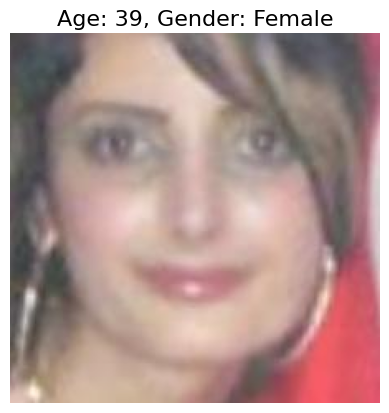

In [9]:
# Create the train and validation datasets
train_dataset = GenderAgeDataset(train_df)
val_dataset = GenderAgeDataset(val_df)

# Create the train and validation dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=val_dataset.collate_fn)

# Check the first batch of the train loader
images, ages, genders = next(iter(train_loader))

# Print the shape of the images and labels in the batch
print(f'Images shape: {images.shape}\nAges shape: {ages.shape}\nGenders shape: {genders.shape}')

# Plot the first image in the batch
image = images[0].permute(1, 2, 0).cpu().numpy() # Convert from tensor to numpy array
image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # Normalize the image to bring it back to the original
age = int(ages[0].item()*80)
gender = 'Female' if int(genders[0].item()) else 'Male'
plot_img(image, f'Age: {age}, Gender: {gender}')

In [10]:
# Create a function to retrieve the dataloaders
def load_data(batch_size):
    train_dataset = GenderAgeDataset(train_df)
    train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)

    val_dataset = GenderAgeDataset(val_df)
    val_dl = DataLoader(val_dataset, batch_size=batch_size, collate_fn=val_dataset.collate_fn)

    return train_dl, val_dl

In [11]:
# Create a class for the age estimation and gender classification model layers
class AgeGenderClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.intermediate = nn.Sequential(
            nn.Linear(2048,512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128,64),
            nn.ReLU(),
        )
        self.age_classifier = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        self.gender_classifier = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.intermediate(x)
        age = self.age_classifier(x)
        gender = self.gender_classifier(x)
        return age, gender

In [12]:
# Create a function to load the VGG16 model and replace the last layers according to our needs
def load_model():
    model = models.vgg16(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False # Freeze all layers
    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    model.classifier = AgeGenderClassifier()
    age_criterion = nn.L1Loss()
    gender_criterion = nn.BCELoss()
    loss_functions = age_criterion, gender_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)

    return model.to(device), loss_functions, optimizer

In [13]:
# Print model summary
model_summary, _, _ = load_model()
summary(model_summary, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 96.0MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [14]:
# Create a function to train the model on a batch of data
def train_batch(model, data, criteria, optimizer):
    model.train()
    optimizer.zero_grad()
    images, ages, genders = data
    pred_ages, pred_genders = model(images)
    age_criterion, gender_criterion = criteria
    age_loss = age_criterion(pred_ages.squeeze(), ages)
    gender_loss = gender_criterion(pred_genders.squeeze(), genders)
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    return total_loss

# Create a function to validate the model on a batch of data
def validate_batch(model, data, criteria):
    model.eval()
    images, ages, genders = data
    with torch.no_grad():
        pred_ages, pred_genders = model(images)
    age_criterion, gender_criterion = criteria
    age_loss = age_criterion(pred_ages.squeeze(), ages)
    gender_loss = gender_criterion(pred_genders.squeeze(), genders)
    total_loss = gender_loss + age_loss
    pred_genders = (pred_genders > 0.5).squeeze()
    gender_acc = (pred_genders == genders).float().sum()
    age_mae = torch.abs(ages - pred_ages).float().sum()
    return total_loss, age_mae, gender_acc

In [15]:
# Train the model
model, criteria, optimizer = load_model()
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, val_gender_accuracies, val_age_maes = [], [], [], []
n_epochs = 5
best_test_loss = 1000
start = time.time()

for epoch in range(n_epochs):
    epoch_train_losses, epoch_val_losses = 0, 0
    epoch_val_age_maes, epoch_val_gender_accs, counter = 0, 0, 0

    for data in train_dl:
        loss = train_batch(model, data, criteria, optimizer)
        epoch_train_losses += loss.item()

    for data in val_dl:
        loss, age_mae, gender_acc = validate_batch(model, data, criteria)
        epoch_val_losses += loss.item()
        epoch_val_age_maes += age_mae
        epoch_val_gender_accs += gender_acc
        counter += len(data[0])

    epoch_val_age_maes /= counter
    epoch_val_gender_accs /= counter
    epoch_train_losses /= len(train_dl)
    epoch_val_losses /= len(val_dl)

    elapsed = time.time()-start
    best_test_loss = min(best_test_loss, epoch_val_losses)
    print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(epoch+1, n_epochs, time.time()-start, (n_epochs-epoch)*(elapsed/(epoch+1))))
    info = f'''Epoch: {epoch+1:03d}\tTrain Loss: {epoch_train_losses:.3f}\tTest: {epoch_val_losses:.3f}\tBest Test Loss: {best_test_loss:.4f}'''
    info += f'\nGender Accuracy: {epoch_val_gender_accs*100:.2f}%\tAge MAE: {epoch_val_age_maes:.2f}\n'
    print(info)

    val_gender_accuracies.append(epoch_val_gender_accs)
    val_age_maes.append(epoch_val_age_maes)
    losses.append(epoch_train_losses)
    val_losses.append(epoch_val_losses)

1/5 (647.08s - 3235.40s remaining)
Epoch: 001	Train Loss: 0.553	Test: 0.470	Best Test Loss: 0.4703
Gender Accuracy: 82.94%	Age MAE: 6.17

2/5 (1295.31s - 2590.61s remaining)
Epoch: 002	Train Loss: 0.402	Test: 0.449	Best Test Loss: 0.4492
Gender Accuracy: 84.32%	Age MAE: 6.18

3/5 (1943.51s - 1943.51s remaining)
Epoch: 003	Train Loss: 0.285	Test: 0.497	Best Test Loss: 0.4492
Gender Accuracy: 84.22%	Age MAE: 6.15

4/5 (2591.70s - 1295.85s remaining)
Epoch: 004	Train Loss: 0.197	Test: 0.591	Best Test Loss: 0.4492
Gender Accuracy: 83.74%	Age MAE: 6.31

5/5 (3247.48s - 649.50s remaining)
Epoch: 005	Train Loss: 0.157	Test: 0.725	Best Test Loss: 0.4492
Gender Accuracy: 83.91%	Age MAE: 6.32



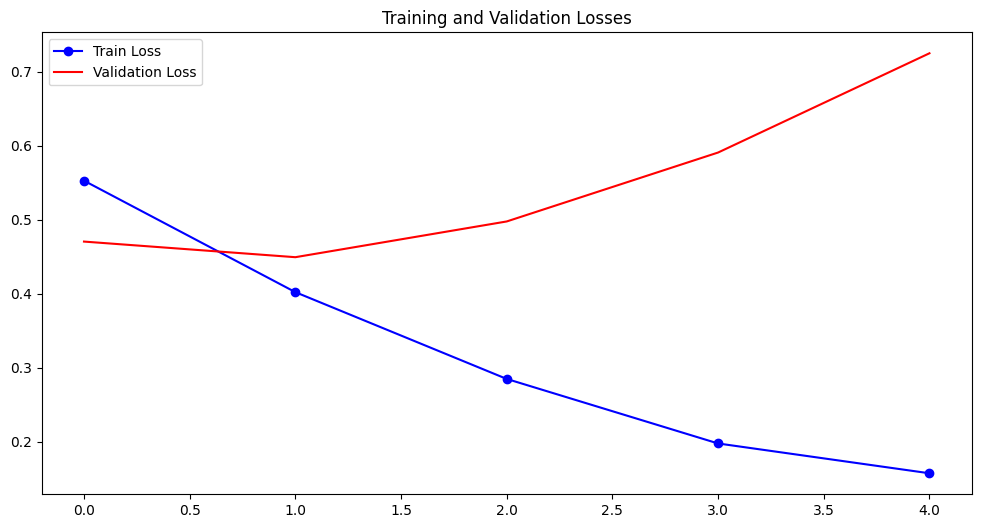

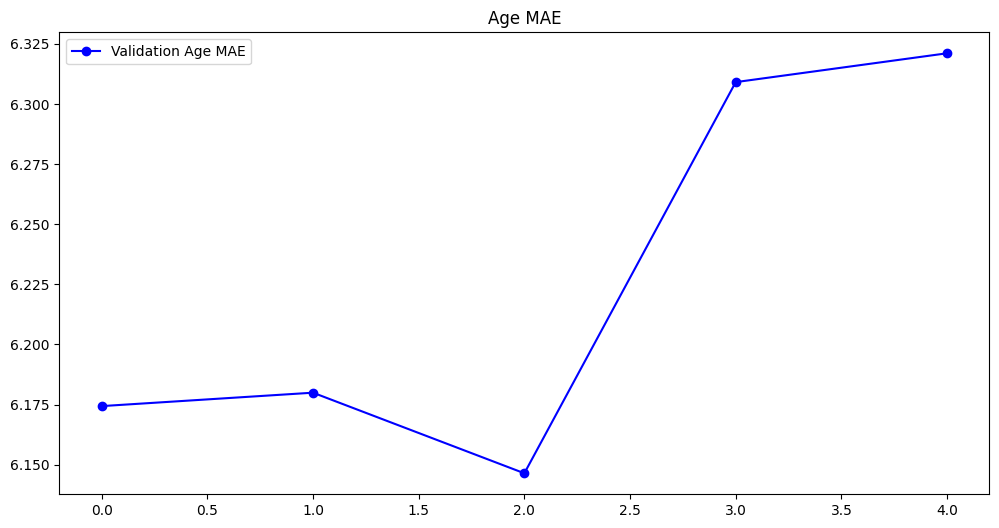

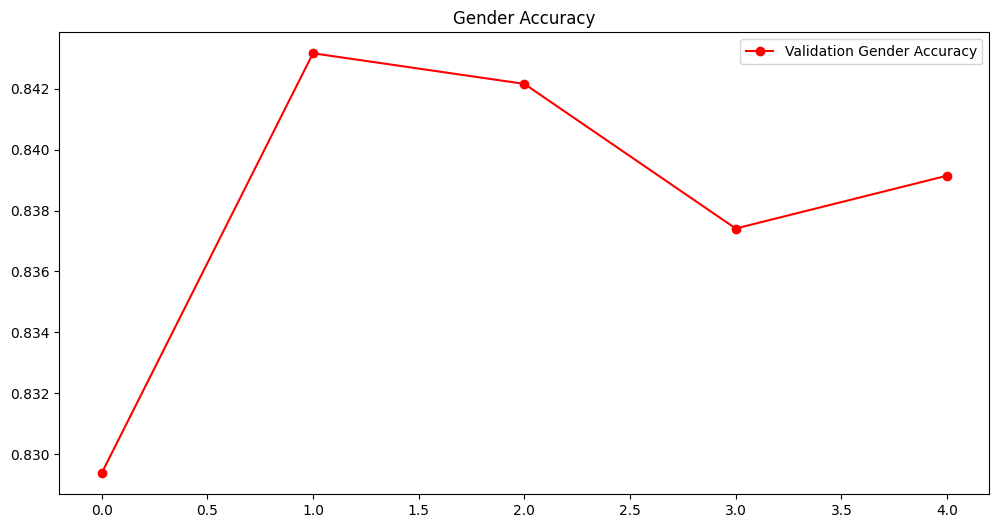

In [16]:
# Convert the lists of tensors to lists of numbers
val_age_maes = [mae.item() for mae in val_age_maes]
val_gender_accuracies = [acc.item() for acc in val_gender_accuracies]

# Plot the training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Train Loss', color='blue', marker='o')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

# Plot val_age_maes
plt.figure(figsize=(12, 6))
plt.plot(val_age_maes, label='Validation Age MAE', color='blue', marker='o')
plt.legend()
plt.title('Age MAE')
plt.show()

# Plot val_gender_accuracies
plt.figure(figsize=(12, 6))
plt.plot(val_gender_accuracies, label='Validation Gender Accuracy', color='red', marker='o')
plt.legend()
plt.title('Gender Accuracy')
plt.show()

--2024-02-19 08:16:29--  https://www.dropbox.com/s/6kzr8l68e9kpjkf/5_9.JPG
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/6kzr8l68e9kpjkf/5_9.JPG [following]
--2024-02-19 08:16:29--  https://www.dropbox.com/s/raw/6kzr8l68e9kpjkf/5_9.JPG
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0fee282f399116c2fdb82feee3.dl.dropboxusercontent.com/cd/0/inline/CNmawLQhdzC7Er_Ui6tPnJzaYSqwZ9_Ss_povwNEkl6JWoAMy563VHGUMDmQa7Q0DSEF8xOBM6yZAt5You5iOM1id7vKRuZQaikkU36aF1r7a1hTl22r6MUjY4nSvvfzVBYqYu2lrhYZZ3t-jdvkB_4i/file# [following]
--2024-02-19 08:16:30--  https://uc0fee282f399116c2fdb82feee3.dl.dropboxusercontent.com/cd/0/inline/CNmawLQhdzC7Er_Ui6tPnJzaYSqwZ9_Ss_povwNEkl6JWoAMy563VHGUMDmQa7Q0DSEF8xOBM6yZAt5You5iOM1id7vKRuZQaikkU36aF1r7a1hTl22r6

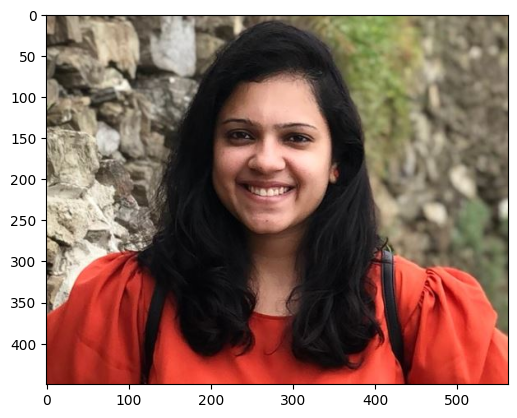

In [23]:
# Make a prediction and plot the image
!wget https://www.dropbox.com/s/6kzr8l68e9kpjkf/5_9.JPG
image = cv2.imread('/content/5_9.JPG')
image = train_dataset.preprocess_image(image).to(device)
age, gender = model(image)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()
image = cv2.imread('/content/5_9.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plot_img(image, 'Predicted gender:',np.where(pred_gender[0][0]<0.5,'Male','Female'),'\nPredicted age:', int(pred_age[0][0]*80))

## torch_snippets library

In [15]:
# Install and import torch_snippets library
!pip install torch_snippets
from torch_snippets import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 67.2 MB/s eta 

In [16]:
# Take a look again at the trainin dataset
train_df.head()

,file,age,gender,race,service_test
0,/content/data/FairFace/train/1.jpg,59,Male,East Asian,True
1,/content/data/FairFace/train/2.jpg,39,Female,Indian,False
2,/content/data/FairFace/train/3.jpg,11,Female,Black,False
3,/content/data/FairFace/train/4.jpg,26,Female,Indian,True
4,/content/data/FairFace/train/5.jpg,26,Female,Indian,True


In [17]:
# Modify Dataset class to use torch_snippets
class GenderAgeDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        f = self.df.iloc[idx].squeeze()
        file = f.file
        image = read(file, 1)
        gender = f.gender == 'Female'
        age = f.age
        return image, age, gender

    def preprocess_image(self, image):
        image = cv2.resize(image, (224, 224))
        image = transforms.ToTensor()(image)
        image = self.normalize(image)
        return image[None]

    def collate_fn(self, batch):
        images, ages, genders = [], [], []
        for image, age, gender in batch:
            images.append(self.preprocess_image(image))
            ages.append(age/80) # Normalize age with max age
            genders.append(float(gender))
        return torch.cat(images).to(device), torch.tensor(ages).float().to(device), torch.tensor(genders).float().to(device)

In [18]:
# Create the train and validation datasets
train_dataset = GenderAgeDataset(train_df)
val_dataset = GenderAgeDataset(val_df)

# Create the train and validation dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=val_dataset.collate_fn)

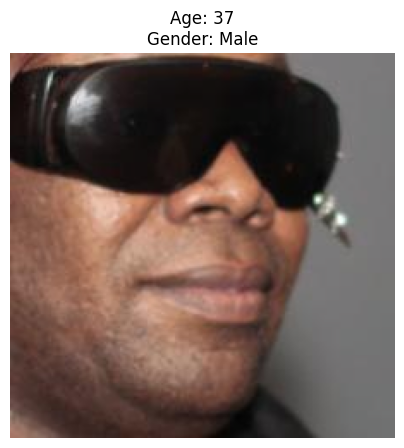

In [19]:
# Show an image from the training dataset using a torch_snippets function
images, ages, genders = next(iter(train_loader))

# Plot the first image in the batch
image = images[0].permute(1, 2, 0).cpu().numpy() # Convert from tensor to numpy array
image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # Normalize the image to bring it back to the original
age = int(ages[0].item()*80)
gender = 'Female' if int(genders[0].item()) else 'Male'
show(image, title=f'Age: {age}\nGender: {gender}', sz=5)

In [20]:
# Inspect the next value in the dataloader using a torch_snippets function
images, genders, ages = next(iter(train_loader))
inspect(images, genders, ages)

══════════════════════════════════════════════════════════════════

tensor([[[[-1.6213, -1.6898, -1.7754,  ..., -2.1179, -2.1179, -2.1179],
          [-1.6213, -1.7240, -1.7925,  ..., -2.1179, -2.1179, -2.1179],
          [-1.6727, -1.7412, -1.7925,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-0.1999, -0.0116,  0.1426,  ..., -1.6727, -1.7240, -1.7583],
          [ 0.0227, -0.2171,  0.0569,  ..., -1.6555, -1.7412, -1.7754],
          [ 0.2796, -0.3027, -0.0116,  ..., -1.6555, -1.7412, -1.7754]],

         [[-1.6155, -1.6856, -1.7381,  ..., -2.0357, -2.0357, -2.0357],
          [-1.6155, -1.7206, -1.7556,  ..., -2.0357, -2.0357, -2.0357],
          [-1.6681, -1.7381, -1.7556,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-0.8452, -0.6527, -0.5301,  ..., -1.5805, -1.6331, -1.6681],
          [-0.6176, -0.8627, -0.6176,  ..., -1.5630, -1.6506, -1.6856],
          [-0.3550, -0.9503, -0.6877,  ..., -1.5630, -1.6506, -1.6856]],

         [[-1.4907, -1.5604, -1.6302,  ..., -1.8044, -1.8044, -1.8044],
          [-1.4907, -1.5953, -1.6476,  ..., -1.8044, -1.8044, -1.8044],
          [-1.5081, -1.5779, -1.6476,  ..., -1.8044, -1.8044, -1.8044],
          ...,
          [-1.0550, -0.8981, -0.7587,  ..., -1.3513, -1.4036, -1.4384],
          [-0.8284, -1.1073, -0.8458,  ..., -1.3339, -1.4210, -1.4559],
          [-0.5670, -1.1944, -0.9156,  ..., -1.3339, -1.4210, -1.4559]]],


        [[[-1.5357, -1.5528, -1.5699,  ..., -1.8953, -1.8953, -1.8953],
          [-1.5357, -1.5528, -1.5870,  ..., -1.9124, -1.8953, -1.8953],
          [-1.5357, -1.5528, -1.5870,  ..., -1.9124, -1.9124, -1.8953],
          ...,
          [ 0.9474,  0.9474,  0.9646,  ...,  1.2557,  1.2557,  1.2557],
          [ 0.9988,  0.9988,  1.0159,  ...,  1.2557,  1.2557,  1.2557],
          [ 1.0331,  1.0502,  1.0502,  ...,  1.2557,  1.2557,  1.2557]],

         [[-1.3529, -1.3704, -1.3880,  ..., -1.7731, -1.7731, -1.7731],
          [-1.3529, -1.3704, -1.4055,  ..., -1.7906, -1.7731, -1.7731],
          [-1.3529, -1.3704, -1.4055,  ..., -1.7906, -1.7906, -1.7731],
          ...,
          [ 1.0455,  1.0455,  1.0630,  ...,  1.3957,  1.3957,  1.3957],
          [ 1.0980,  1.0980,  1.1155,  ...,  1.3957,  1.3957,  1.3957],
          [ 1.1331,  1.1506,  1.1506,  ...,  1.3957,  1.3957,  1.3957]],

         [[-1.2293, -1.2467, -1.2293,  ..., -1.5604, -1.5604, -1.5604],
          [-1.2293, -1.2467, -1.2467,  ..., -1.5779, -1.5604, -1.5604],
          [-1.2293, -1.2467, -1.2467,  ..., -1.5779, -1.5779, -1.5604],
          ...,
          [ 1.1759,  1.1759,  1.1934,  ...,  1.5768,  1.5768,  1.5768],
          [ 1.2282,  1.2282,  1.2457,  ...,  1.5768,  1.5768,  1.5768],
          [ 1.2631,  1.2805,  1.2805,  ...,  1.5768,  1.5768,  1.5768]]],


        [[[ 0.2796,  0.2624,  0.2624,  ...,  0.7077,  0.6734,  0.6392],
          [ 0.2282,  0.2282,  0.2453,  ...,  0.6906,  0.6563,  0.6392],
          [ 0.2282,  0.2282,  0.2453,  ...,  0.6734,  0.6563,  0.6392],
          ...,
          [-0.3198, -0.2856, -0.2342,  ...,  0.6049,  0.5878,  0.5707],
          [-0.2856, -0.2513, -0.1999,  ...,  0.5878,  0.5707,  0.5707],
          [-0.2684, -0.2342, -0.1828,  ...,  0.5707,  0.5707,  0.5536]],

         [[-0.6001, -0.6176, -0.6176,  ...,  0.8704,  0.8354,  0.8004],
          [-0.6527, -0.6527, -0.6352,  ...,  0.8529,  0.8179,  0.8004],
          [-0.6877, -0.6877, -0.6702,  ...,  0.8354,  0.8179,  0.8004],
          ...,
          [-1.1604, -1.1253, -1.0728,  ...,  0.7479,  0.7304,  0.7129],
          [-1.1253, -1.0903, -1.0378,  ...,  0.7304,  0.7129,  0.7129],
          [-1.1078, -1.0728, -1.0203,  ...,  0.7129,  0.7129,  0.6954]],

         [[-0.5844, -0.6018, -0.6018,  ...,  0.9494,  0.9145,  0.8797],
          [-0.6367, -0.6367, -0.6193,  ...,  0.9319,  0.8971,  0.8797],
          [-0.6541, -0.6541, -0.6367,  ...,  0.9145,  0.8971,  0.8797],
          ...,
          [-1.0550, -1.0201, -0.9678,  ...,  0.9319,  0.9145,  0.8971],
          [-1.0201, -0.9853, -0.9330,  ...,  0.9145,  0.8971,  0.8971],
          [-1.0027, -0.9678, 

══════════════════════════════════════════════════════════════════

tensor([0.3500, 0.2875, 0.5625, 0.3625, 0.5375, 0.0500, 0.0375, 0.0375, 0.3875,
        0.4125, 0.3750, 0.3000, 0.1500, 0.2625, 0.6000, 0.3875, 0.3500, 0.3875,
        0.3250, 0.3750, 0.3000, 0.4500, 0.1500, 0.7375, 0.4750, 0.4750, 0.6250,
        0.6625, 0.4500, 0.5875, 0.4750, 0.1500], device='cuda:0')

══════════════════════════════════════════════════════════════════

tensor([1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
       device='cuda:0')

══════════════════════════════════════════════════════════════════

EPOCH: 1.000  val_loss: 0.462  val_gender_acc: 0.834  val_age_mae: 6.089  train_loss: 0.549  (722.64s - 2890.56s remaining)
EPOCH: 2.000  val_loss: 0.464  val_gender_acc: 0.835  val_age_mae: 6.288  train_loss: 0.400  (1414.55s - 2121.83s remaining)
EPOCH: 3.000  val_loss: 0.495  val_gender_acc: 0.842  val_age_mae: 6.381  train_loss: 0.283  (2105.68s - 1403.79s remaining)
EPOCH: 4.000  val_loss: 0.608  val_gender_acc: 0.841  val_age_mae: 6.441  train_loss: 0.196  (2797.02s - 699.26s remaining)
EPOCH: 5.000  val_loss: 0.682  val_gender_acc: 0.836  val_age_mae: 6.354  train_loss: 0.157  (3488.02s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 288.28it/s]


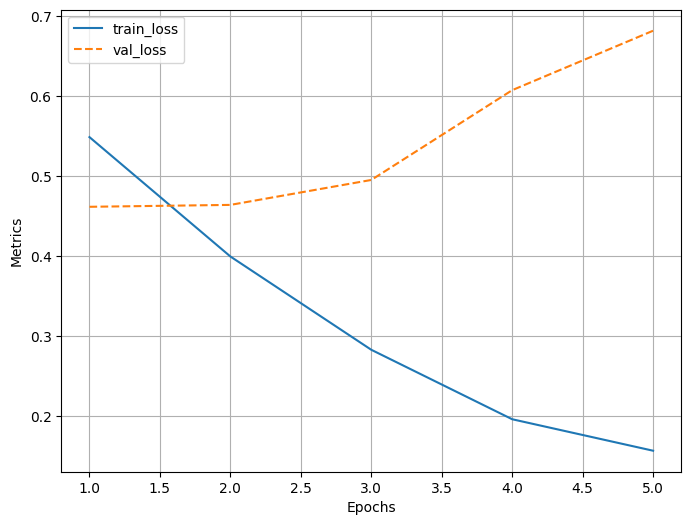

In [21]:
# Train the model using torch_snippets
model, criteria, optimizer = load_model()
batch_size = 32
train_dl, val_dl = load_data(batch_size)
n_epochs = 5
log = Report(n_epochs)

for epoch in range(n_epochs):
    n = len(train_dl)
    for i, data in enumerate(train_dl):
        loss = train_batch(model, data, criteria, optimizer)
        log.record(epoch+(i+1)/n, train_loss=loss, end='\r')
    n = len(val_dl)
    for i, data in enumerate(val_dl):
        val_loss, val_age_mae, val_gender_acc = validate_batch(model, data, criteria)
        val_age_mae /= len(data[0])
        val_gender_acc /= len(data[0])
        log.record(epoch+(i+1)/n, val_loss=val_loss, val_age_mae=val_age_mae, val_gender_acc=val_gender_acc, end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['train_loss', 'val_loss'])

--2024-02-22 03:04:22--  https://www.dropbox.com/s/6kzr8l68e9kpjkf/5_9.JPG
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/6kzr8l68e9kpjkf/5_9.JPG [following]
--2024-02-22 03:04:22--  https://www.dropbox.com/s/raw/6kzr8l68e9kpjkf/5_9.JPG
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc686d8aca0cdda5f64c4f2d48ba.dl.dropboxusercontent.com/cd/0/inline/CNuv8u6ndRUMGVSLLA9NBPI3RcbSh6Wkew8hTM3HPnQ2tBXrmtAq3GKLaBSZeT713y9V6KqX_4TZXi7SyDyXnT-8AspTdszx3XwixtRsq61k0ePUTgtlo3pUwyTLGSH-RqrAKyQepl5F4bnAKqutZLtC/file# [following]
--2024-02-22 03:04:23--  https://uc686d8aca0cdda5f64c4f2d48ba.dl.dropboxusercontent.com/cd/0/inline/CNuv8u6ndRUMGVSLLA9NBPI3RcbSh6Wkew8hTM3HPnQ2tBXrmtAq3GKLaBSZeT713y9V6KqX_4TZXi7SyDyXnT-8AspTdszx3XwixtRsq61k0ePUTgtlo

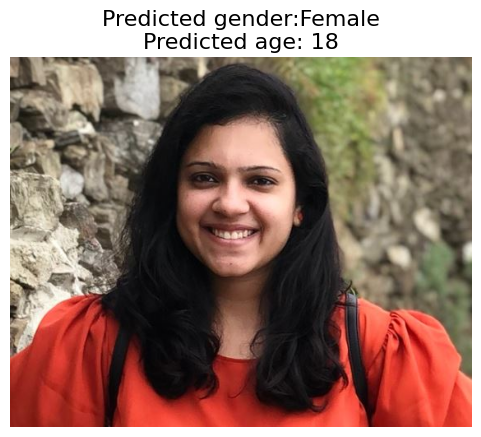

In [24]:
# Make a prediction and plot the image
!wget https://www.dropbox.com/s/6kzr8l68e9kpjkf/5_9.JPG
image = cv2.imread('/content/5_9.JPG')
image = train_dataset.preprocess_image(image).to(device)
age, gender = model(image)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()
image = cv2.imread('/content/5_9.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
age = int(pred_age[0][0]*80)
gender = np.where(pred_gender[0][0]<0.5,'Male','Female')
plot_img(image, f'Predicted gender:{gender}\nPredicted age: {age}')